In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
import sys
py_file_location = "/content/drive/MyDrive/Tesis/Red"
sys.path.append(os.path.abspath(py_file_location))

Mounted at /content/drive


In [ ]:
import importlib

import Funciones.visualizacion as visualizacion
import Funciones.Generador as Generador
import Funciones.Discriminador as Discriminador
import Funciones.auxiliares as auxiliares

importlib.reload(auxiliares)

<module 'Funciones.auxiliares' from '/content/drive/MyDrive/Tesis/Red/Funciones/auxiliares.py'>

In [ ]:
import torch
from torch import nn

from tqdm.auto import tqdm # Progress bar

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST #noned

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(0) # Set for our testing purposes, please do not change!



criterion: the loss function

n_epochs: the number of times you iterate through the entire 
dataset when training

z_dim: the dimension of the noise vector

display_step: how often to display/visualize the images

batch_size: the number of images per forward/backward pass

lr: the learning rate

device: the device type

In [ ]:
mnist_shape = (1, 28, 28) #tamaño imagen
n_classes = 10 # numkero etiquetas
cuda0 = torch.device('cuda:0')

criterion = nn.BCEWithLogitsLoss()
n_epochs = 2
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
device = cuda0

In [ ]:
# transform talves a funcion
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

#cargar datos
dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [ ]:
generator_input_dim, discriminator_im_chan = auxiliares.get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generador.Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminador.Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

gen = gen.apply(auxiliares.weights_init)
disc = disc.apply(auxiliares.weights_init)

In [ ]:
cur_step = 0
generator_losses = []
discriminator_losses = []

#UNIT TEST NOTE: Initializations needed for grading
noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(n_epochs): 
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)

        one_hot_labels = auxiliares.get_one_hot_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])

        ### Update discriminator ###
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size 
        fake_noise = auxiliares.get_noise(cur_batch_size, z_dim, device=device)
        
        # Now you can get the images from the generator
        # Steps: 1) Combine the noise vectors and the one-hot labels for the generator
        #        2) Generate the conditioned fake images
       
        noise_and_labels = auxiliares.combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)#gen.forward(noise_and_labels) no usar

        # Now you can get the predictions from the discriminator
        # Steps: 1) Create the input for the discriminator
        #           a) Combine the fake images with image_one_hot_labels, 
        #              remember to detach the generator (.detach()) so you do not backpropagate through it
        #           b) Combine the real images with image_one_hot_labels
        #        2) Get the discriminator's prediction on the fakes as disc_fake_pred
        #        3) Get the discriminator's prediction on the reals as disc_real_pred
        
        fake_image_and_labels = auxiliares.combine_vectors(fake.detach(), image_one_hot_labels)
        real_image_and_labels = auxiliares.combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels)
        disc_real_pred = disc(real_image_and_labels)       
        
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ### Update generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()

        fake_image_and_labels = auxiliares.combine_vectors(fake, image_one_hot_labels)
        # This will error if you didn't concatenate your labels to your image correctly
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]
        #

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            visualizacion.show_tensor_images(fake)
            visualizacion.show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!")
        cur_step += 1

  0%|          | 0/469 [00:00<?, ?it/s]

Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!


In [ ]:
# Before you explore, you should put the generator
# in eval mode, both in general and so that batch norm
# doesn't cause you issues and is using its eval statistics
gen = gen.eval()

tensor([[0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.9286, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0714,
         0.0000],
        [0.0000, 0.8571, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1429,
         0.0000],
        [0.0000, 0.7857, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2143,
         0.0000],
        [0.0000, 0.7143, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2857,
         0.0000],
        [0.0000, 0.6429, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3571,
         0.0000],
        [0.0000, 0.5714, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4286,
         0.0000],
        [0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000,
         0.0000],
        [0.0000, 0.4286, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5714,
         0.0000],
        [0.0000, 0.3571, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6429,
         0.0000],
        [0

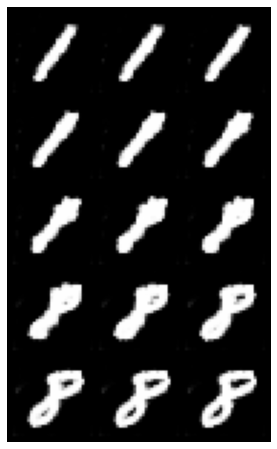

In [ ]:
import math

### Change me! ###
n_interpolation = 15 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)
interpolation_noise = auxiliares.get_noise(1, z_dim, device=device).repeat(n_interpolation, 1)

def interpolate_class(first_number, second_number):
    first_label = auxiliares.get_one_hot_labels(torch.Tensor([first_number]).long(), n_classes)
    second_label = auxiliares.get_one_hot_labels(torch.Tensor([second_number]).long(), n_classes)

    # Calculate the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label
    print(interpolation_labels)
    # Combine the noise and the labels
    noise_and_labels = auxiliares.combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    visualizacion.show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

### Change me! ###
start_plot_number = 1 # Choose the start digit
### Change me! ###
end_plot_number = 8 # Choose the end digit

plt.figure(figsize=(8, 8))
interpolate_class(start_plot_number, end_plot_number)
_ = plt.axis('off')

### Uncomment the following lines of code if you would like to visualize a set of pairwise class 
### interpolations for a collection of different numbers, all in a single grid of interpolations.
### You'll also see another visualization like this in the next code block!
#plot_numbers = [2, 3, 4, 5, 7]
#n_numbers = len(plot_numbers)
#plt.figure(figsize=(8, 8))
#for i, first_plot_number in enumerate(plot_numbers):
#    for j, second_plot_number in enumerate(plot_numbers):
#        plt.subplot(n_numbers, n_numbers, i * n_numbers + j + 1)
#        interpolate_class(first_plot_number, second_plot_number)
#        plt.axis('off')
#plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
#plt.show()
#plt.close()

[tensor([[-0.8634, -0.5653, -1.2478, -0.1097,  0.8920, -1.4117, -0.1281,  1.8160,
         -0.9748, -0.9792,  0.0421,  2.3408,  0.9139,  1.2400,  0.9792,  1.0584,
          2.6857,  0.1428,  1.1870, -1.0402, -1.5085, -0.3562, -0.3740,  0.4499,
         -0.8387, -0.5911, -2.7430,  0.5613, -1.8285,  1.1127, -0.3610, -0.1434,
          0.5037,  2.5220, -0.3630, -0.4621,  1.1902,  0.6625,  1.6594,  0.5820,
          1.8421,  0.9597, -1.5114, -0.4912, -0.0164, -0.1645, -1.5930, -0.1005,
          1.1693,  0.3297, -0.5576,  0.3419, -0.0560,  0.2507,  0.4723,  0.3421,
         -1.8046, -1.4288,  1.7667,  0.7384, -2.2843,  0.3260,  0.3361,  1.8616]],
       device='cuda:0'), tensor([[ 0.7842, -0.2100,  0.3782, -1.0010,  0.8179, -1.5331, -0.5778,  0.6732,
          0.2346, -0.1427, -1.0522,  0.4765,  0.8286, -0.4100, -0.4969,  0.0107,
          0.2212,  1.7589, -0.0981,  1.8507,  1.0744,  0.3204,  0.9630, -0.8094,
          0.2465,  1.2331,  0.2904,  1.0098,  1.6356, -0.6362,  0.0739, -1.1506,


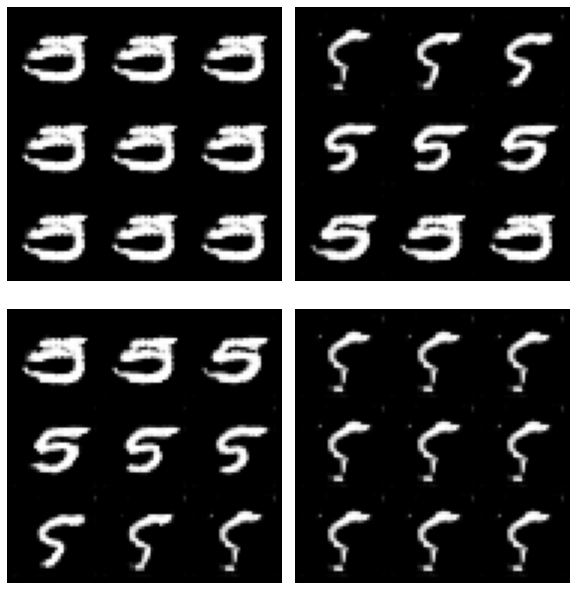

In [ ]:
n_interpolation = 9 # How many intermediate images you want + 2 (for the start and end image)

# This time you're interpolating between the noise instead of the labels
interpolation_label = auxiliares.get_one_hot_labels(torch.Tensor([5]).long(), n_classes).repeat(n_interpolation, 1).float()

def interpolate_noise(first_noise, second_noise):
    # This time you're interpolating between the noise instead of the labels
    percent_first_noise = torch.linspace(0, 1, n_interpolation)[:, None].to(device)
    interpolation_noise = first_noise * percent_first_noise + second_noise * (1 - percent_first_noise)
    print(interpolation_noise)
    # Combine the noise and the labels again
    noise_and_labels = auxiliares.combine_vectors(interpolation_noise, interpolation_label.to(device))
    fake = gen(noise_and_labels)
    visualizacion.show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

# Generate noise vectors to interpolate between
### Change me! ###
n_noise = 2 # Choose the number of noise examples in the grid
plot_noises = [auxiliares.get_noise(1, z_dim, device=device) for i in range(n_noise)]
print(plot_noises)
plt.figure(figsize=(8, 8))
for i, first_plot_noise in enumerate(plot_noises):
    for j, second_plot_noise in enumerate(plot_noises):
        plt.subplot(n_noise, n_noise, i * n_noise + j + 1)
        interpolate_noise(first_plot_noise, second_plot_noise)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()